## Problem 1: Visualise data in an interactive map (10 points)


Create an *interactive* **thematic map** using the skills you learnt during lesson 5. You can use *Folium*,<br>
or any other suitable Python package - feel free to experiment).

The map should contain more than one layer (from at least two different data sets). Pay attention to <br>
classification and visualisation (appropriate colour scheme choice, etc.). Write your code in this <br>
notebook, and store the resulting maps in `.html` format (plus possibly additional files, depending on<br>
your approach) in the `NOTEBOOK_DIRECTORY / "docs"` folder.

### Topic of the map

- Use any of the data sets we have used during the course (travel time data, population grid), or <br>
  any other data set of your interest (for example, [open data sets from Statistics Finland](https://www.stat.fi/org/avoindata/index_en.html), <br>
  or the open geo-data from [the Helsinki Region Infoshare](https://hri.fi/en)). If you download <br>
  data sets, add, commit, and push them to the `DATA_DIRECTORY`. Be sure to include an attribution <br>
  to each data set in your output map!
- Feel free to start from and adapt examples from the course material! You can take one step further <br>
  and add additional analysis to, e.g., the shopping centre dominance or the population within vincinity <br>
  of certain addresses)
- This should **not** be an interactive version of your submission for *problem 1*! Create something new!

### Criteria

- The map has more than one data layer (for instance, the results of an analysis, and the road network <br>
  to illustrate a complex spatial pattern). If (and only if) you think it adds additional value, feel <br>
  free to add a base map (but a base map does not count as an own layer)
- The map portrays the output of an analysis or a classification that adds value beyond just displaying <br>
  the raw data
- The map follows good cartographic practices (appropriate map extent and zoom level, colour scheme, <br>
  legend and data sources, etc.)
- The map demonstrates the skills learnt during lesson 5, interactive elements (popups, etc.) are a plus.

### Output

- Save the map(s) in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder, remember to add, commit, <br>
  and push them to the GitHub repository
- Remember to also add, commit, and push input data sets and code

---

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [54]:
import folium
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [85]:
# Loading data
shopping_centres = gpd.read_file(DATA_DIRECTORY / "shopping_centres.gpkg").to_crs("EPSG:4326")
roads_WFS_URL = (
    "https://kartta.hel.fi/ws/geoserver/avoindata/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&srsName=EPSG:3879"
    "&typeName={layer:s}"
).format(layer="avoindata:Seutukartta_liikenne_paatiet")

population_grid = (
    gpd.read_file(
        "https://kartta.hsy.fi/geoserver/wfs"
        "?service=wfs"
        "&version=2.0.0"
        "&request=GetFeature"
        "&typeName=asuminen_ja_maankaytto:Vaestotietoruudukko_2020"
        "&srsName=EPSG:4326"
        "&bbox=24.6,60.1,25.2,60.4,EPSG:4326"
    )
    .set_crs("EPSG:4326")
)

population_grid = population_grid[["index", "asukkaita", "geometry"]]
population_grid = population_grid.rename(columns={
    "asukkaita": "population"
})
population_grid["id"] = population_grid.index.astype(str)

# roads df
roads_df = gpd.read_file(roads_WFS_URL).set_crs("EPSG:3879").to_crs("EPSG:4326")
roads_df = roads_df.dropna()

In [86]:
# Creating 2 km buffers
shopping_centres["two_km_buffer"] = shopping_centres["geometry"].to_crs("EPSG:3857").buffer(2000).to_crs("EPSG:4326")

In [87]:
shopping_centres = shopping_centres.set_geometry("two_km_buffer")

In [88]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
#shopping_centres.plot(ax=ax)
#population_grid.plot(ax=ax)

In [89]:
pop_within_2km_range = population_grid.sjoin(
    shopping_centres,
    how="left",
    predicate="intersects"
)
pop_within_2km_range = pop_within_2km_range.dropna()

<Axes: >

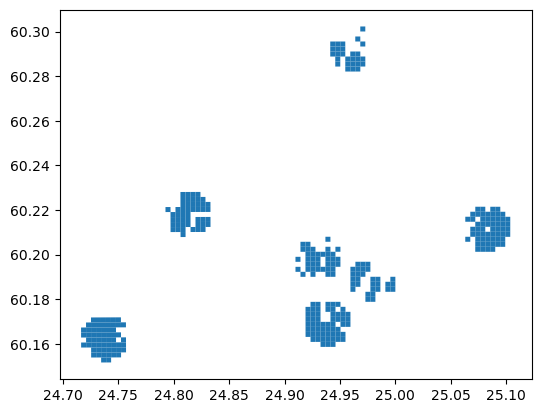

In [90]:
pop_within_2km_range.set_geometry("geometry_left").plot()

In [91]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
#shopping_centres.plot(ax=ax)
#population_grid.plot(ax=ax, color="red")

In [37]:
# ADD YOUR OWN CODE HERE

interactive_map = folium.Map(
    width='50%',
    height='50%',
    location=(60.2, 24.8),
    zoom_start=10,
    control_scale=True
)

population_grid_layer = folium.Choropleth(
    geo_data=population_grid,
    data=population_grid,
    columns=("id", "population"),
    key_on="feature.id"
)
population_grid_layer.add_to(interactive_map)


sh_centers_fg = folium.FeatureGroup("Shopping Centers")

for lat, lon, name in zip(shopping_centres.geometry.y, shopping_centres.geometry.x, shopping_centres.name):
    sh_centers_fg.add_child(
                                folium.Marker(
                                    location=[lat,lon],
                                    popup=name,
                                    icon=folium.Icon(icon="shopping-cart")))

interactive_map.add_child(sh_centers_fg)

# Create a FeatureGroup to hold the linestring
roads_fg = folium.FeatureGroup(name='Roads')

for index, row in roads_df.iterrows():
    folium.GeoJson(row['geometry']).add_to(roads_fg)

# Add the FeatureGroup to the map
roads_fg.add_to(interactive_map)

# Create a FeatureGroup to hold the linestring
shopping_centers_fg = folium.FeatureGroup(name='2km buffers')

for index, row in shopping_centres.iterrows():
    folium.GeoJson(row['two_km_buffer']).add_to(shopping_centers_fg)

# Add the FeatureGroup to the map
shopping_centers_fg.add_to(interactive_map)

interactive_map

In [38]:
# Save
interactive_map.save(OUTPUT_DIRECTORY / "base-map.html")